In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e3', 'e4', 'e5', 'e6']
#aedge='orange'

#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [11]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [12]:
#d = cp.generate_decline(dfc, scale=False)

In [13]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    maxday = t.loc[t[value_col] == t[value_col].max(), x_col].values[0]
    t.loc[:, x_col] = t.loc[:, x_col] - maxday

    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [14]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = dfc.groupby(groupby_cols).apply(convert_func).reset_index() 

In [15]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds.loc[(ds.day < 81) & (ds.day > -11)]

In [16]:
ds.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL
9,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-10,0.299
10,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-9,0.381
11,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-8,0.693
12,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-7,0.959
13,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-6,1.225


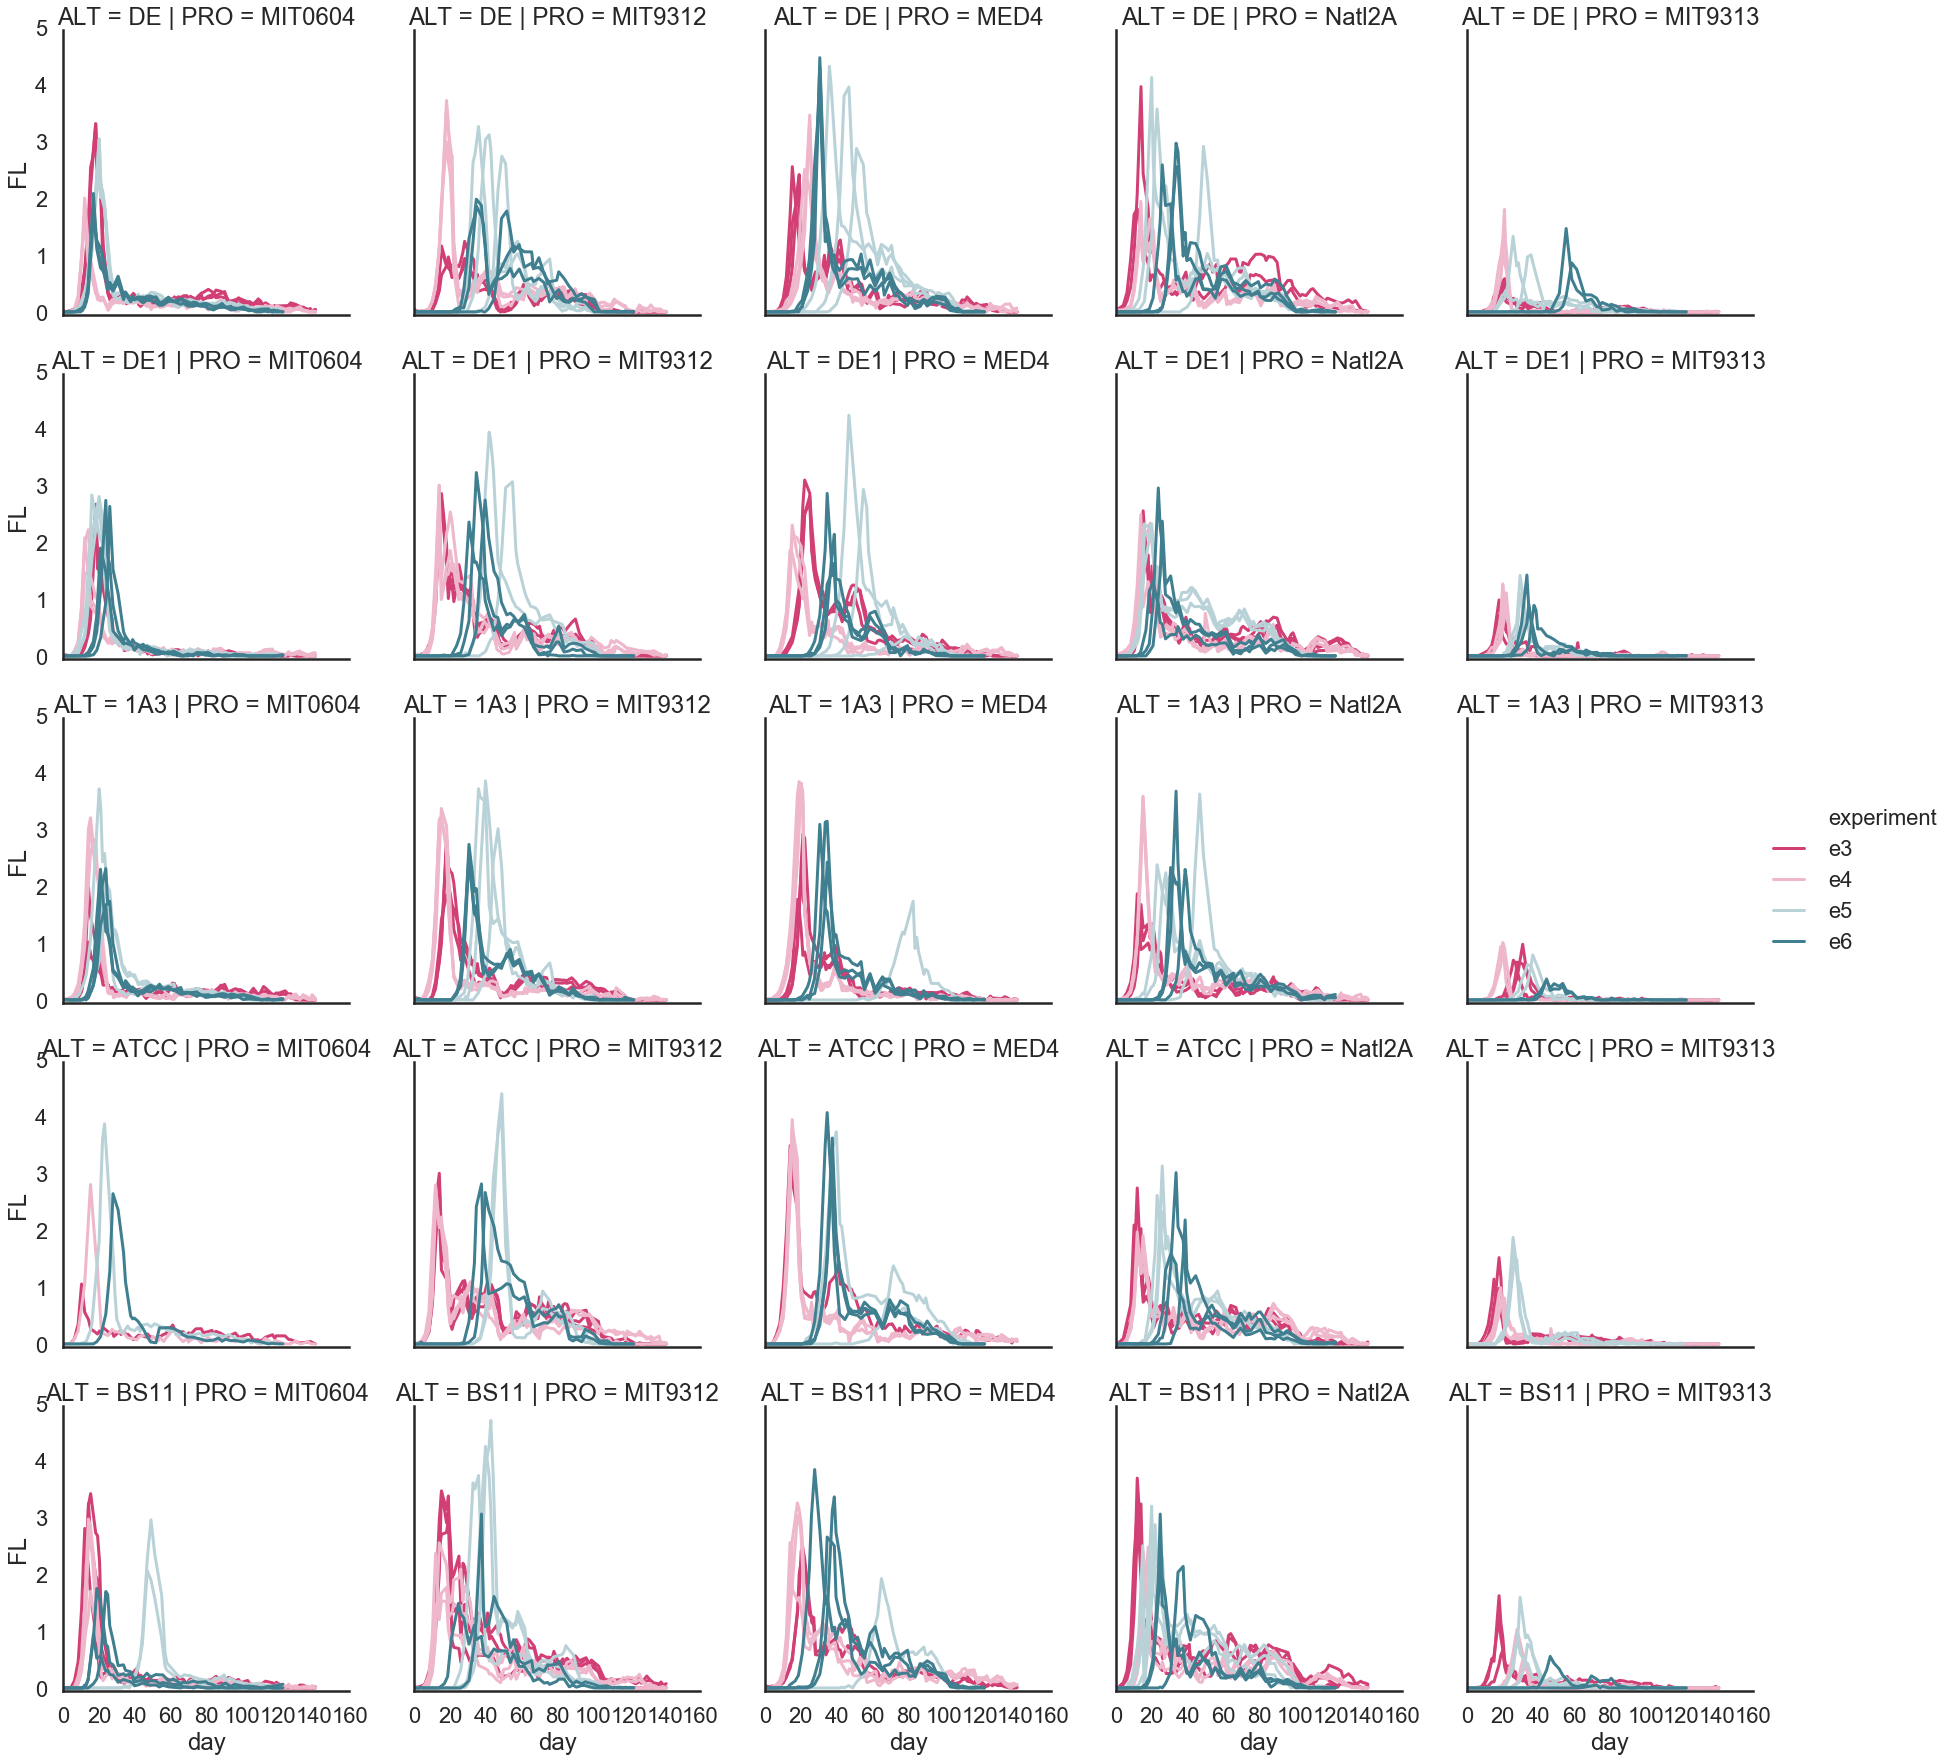

In [17]:
sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

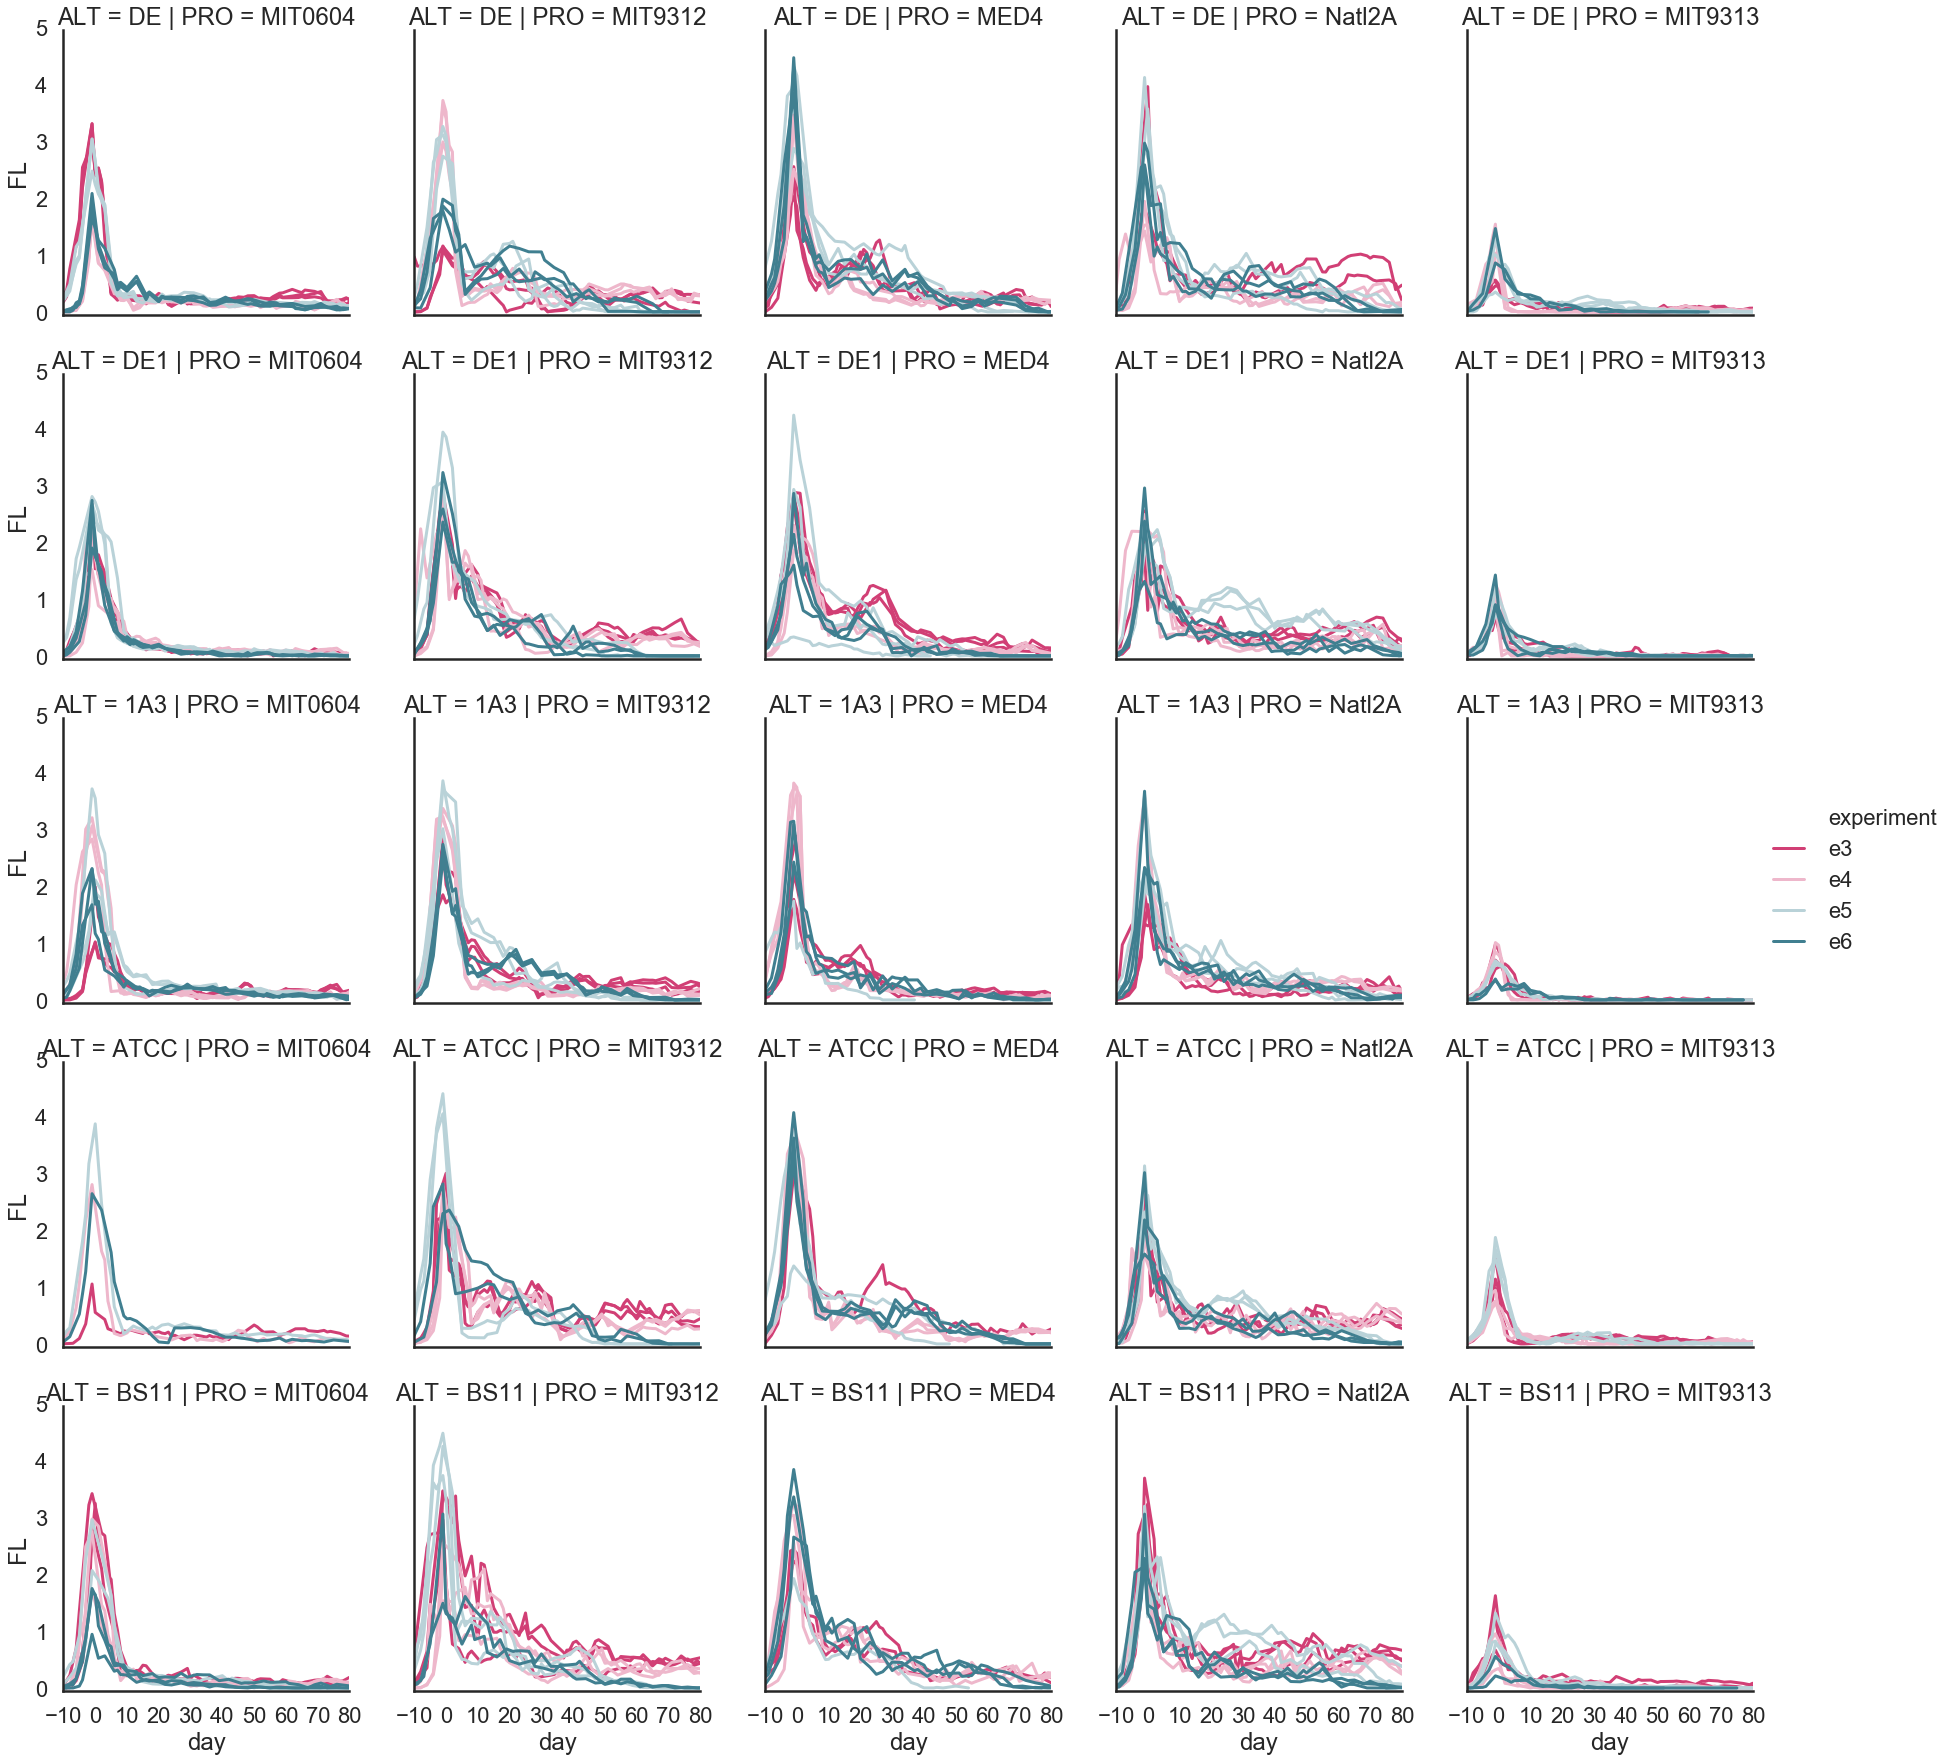

In [18]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

In [19]:
ds['decline'] = ds['FL']

In [20]:
ds34 = ds.loc[ds.experiment.isin(['e3', 'e4'])]
ds56 = ds.loc[ds.experiment.isin(['e5', 'e6'])]

In [21]:
ds34.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL,decline
9,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-10,0.299,0.299
10,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-9,0.381,0.381
11,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-8,0.693,0.693
12,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-7,0.959,0.959
13,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-6,1.225,1.225


In [22]:
train34_df_orig, test34_df_orig = cp.split_train_test(ds34,test_size=0.4)
train56_df_orig, test56_df_orig = cp.split_train_test(ds56,test_size=0.4)

In [23]:
train34_df = cp.augment_training(train34_df_orig, noise_N=3, augment_x=False)
test34_df = test34_df_orig
train56_df = cp.augment_training(train56_df_orig, noise_N=3, augment_x=False)
test56_df = test56_df_orig

In [24]:
train34_df.shape, test34_df.shape, train56_df.shape, test56_df.shape, 

((642096, 10), (5187, 9), (570024, 10), (4625, 9))

In [25]:
train34_df.columns

Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
       'day', 'FL', 'augment_name', 'experiment_sample_orig'],
      dtype='object')

In [26]:
stats34_list = []
y34_list = []
clf34_list = []
features34_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train34_df, test34_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats34_list.extend(res)
y34_list.extend(_y_list)
clf34_list.extend(_clf_list)
features34_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [27]:
stats56_list = []
y56_list = []
clf56_list = []
features56_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train56_df, test56_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats56_list.extend(res)
y56_list.extend(_y_list)
clf56_list.extend(_clf_list)
features56_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [28]:
stats56_df = pd.DataFrame.from_records(stats56_list)
stats34_df = pd.DataFrame.from_records(stats34_list)


In [29]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

,f1_test,accuracy_test,accuracy_train
27,0.788851,0.788462,1.0
22,0.788544,0.788462,1.0
17,0.787753,0.788462,1.0
19,0.786898,0.788462,1.0
2,0.786725,0.788462,1.0
16,0.786725,0.788462,1.0
4,0.786725,0.788462,1.0
1,0.786725,0.788462,1.0
20,0.786725,0.788462,1.0
21,0.786725,0.788462,1.0


In [30]:
stats34_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

,f1_test,accuracy_test,accuracy_train
29,0.947332,0.947368,1.0
12,0.947218,0.947368,1.0
28,0.947218,0.947368,1.0
27,0.947218,0.947368,1.0
25,0.947218,0.947368,1.0
21,0.947218,0.947368,1.0
19,0.947218,0.947368,1.0
17,0.947218,0.947368,1.0
16,0.947218,0.947368,1.0
1,0.947218,0.947368,1.0


In [65]:
idx34 = 29
y34_df =  y34_list[idx34]
clf34 = clf34_list[idx34]
features34 = features34_list[idx34]

In [66]:
y34_df.head()

,PRO_FL_y,PRO_FL_y_PRO,PRO_FL_y_pred,PRO_FL_y_pred_PRO,Type
experiment_sample,,,,,
"e3, 10A, FL_0.05_0_first",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_last",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_max",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_mean",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_median",MIT0604,MIT0604,MIT0604,MIT0604,Train


accuracy: 0.9473684210526315
              precision    recall  f1-score   support

        MED4       1.00      0.92      0.96        13
     MIT0604       0.90      0.90      0.90        10
     MIT9312       0.92      1.00      0.96        11
     MIT9313       0.92      1.00      0.96        12
      Natl2A       1.00      0.91      0.95        11

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57



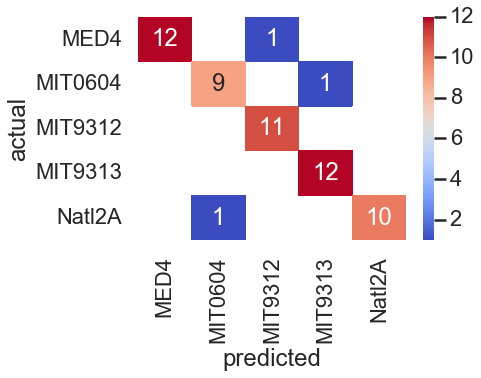

In [67]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y34_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


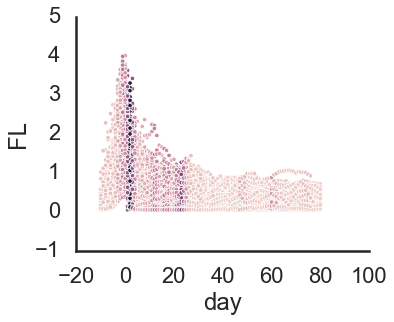

In [68]:
feature_importances34 = pd.DataFrame(clf34.feature_importances_,
                                   index = features34,
                                    columns=['importance'])
merge34df = ds34.merge(feature_importances34, left_on='day', right_index=True, how='left')
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

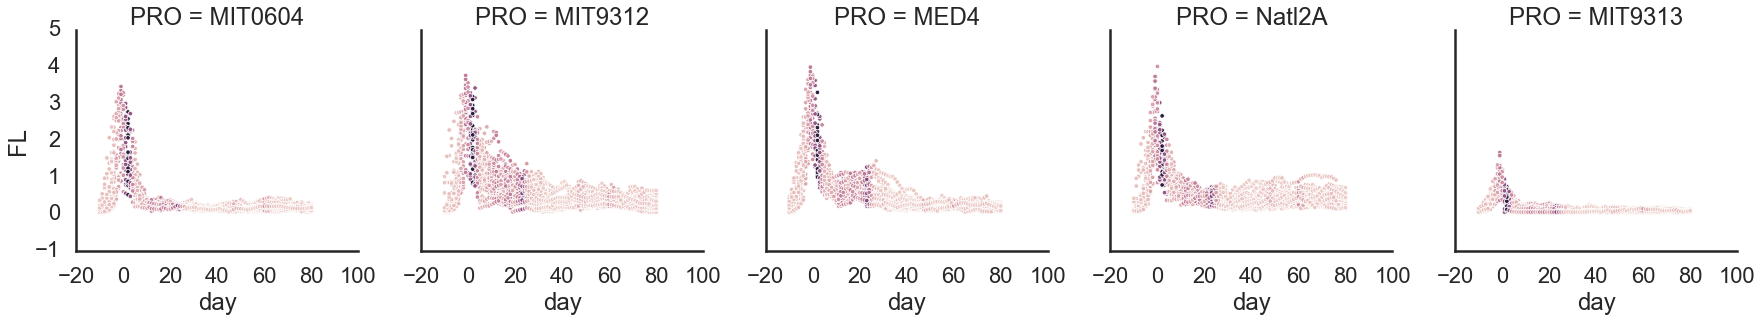

In [69]:
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

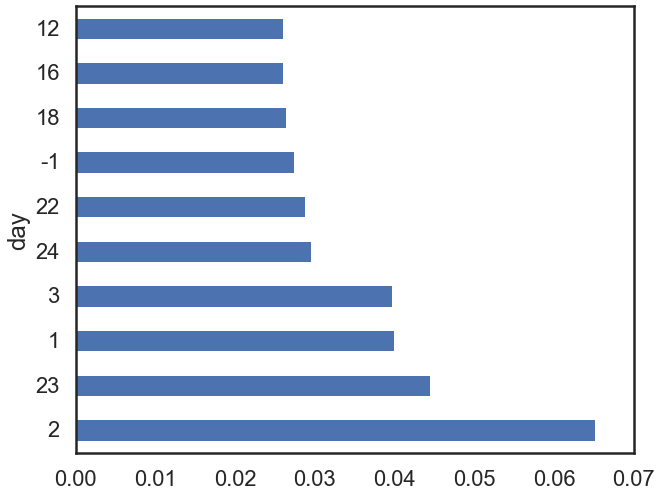

In [70]:
feature_importances34.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [71]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

,f1_test,accuracy_test,accuracy_train
27,0.788851,0.788462,1.0
22,0.788544,0.788462,1.0
17,0.787753,0.788462,1.0
19,0.786898,0.788462,1.0
2,0.786725,0.788462,1.0
16,0.786725,0.788462,1.0
4,0.786725,0.788462,1.0
1,0.786725,0.788462,1.0
20,0.786725,0.788462,1.0
21,0.786725,0.788462,1.0


In [72]:
idx56 = 27
y56_df =  y56_list[idx56]
clf56 = clf56_list[idx56]
features56 = features56_list[idx56]

In [73]:
y56_df.head()

,PRO_FL_y,PRO_FL_y_PRO,PRO_FL_y_pred,PRO_FL_y_pred_PRO,Type
experiment_sample,,,,,
"e5, 10B, FL_0.05_0_first",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_last",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_max",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_mean",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_median",MIT0604,MIT0604,MIT0604,MIT0604,Train


accuracy: 0.7884615384615384
              precision    recall  f1-score   support

        MED4       0.60      0.60      0.60        10
     MIT0604       1.00      0.73      0.84        11
     MIT9312       0.80      0.80      0.80        10
     MIT9313       0.90      1.00      0.95         9
      Natl2A       0.71      0.83      0.77        12

    accuracy                           0.79        52
   macro avg       0.80      0.79      0.79        52
weighted avg       0.80      0.79      0.79        52



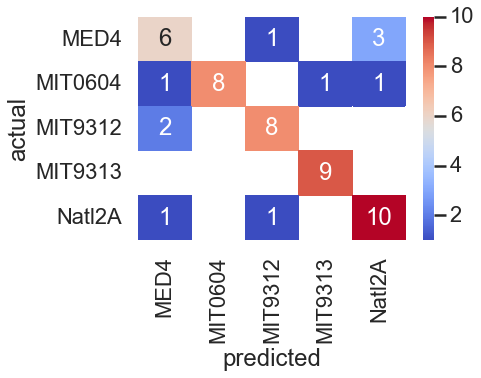

In [74]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y56_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


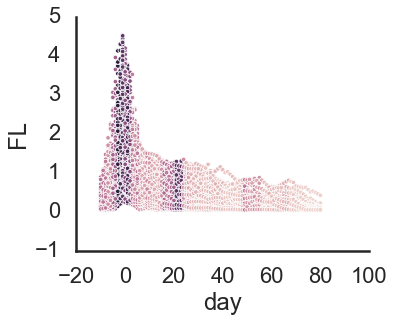

In [75]:
feature_importances56 = pd.DataFrame(clf56.feature_importances_,
                                   index = features56,
                                    columns=['importance'])
merge56df = ds56.merge(feature_importances56, left_on='day', right_index=True, how='left')
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

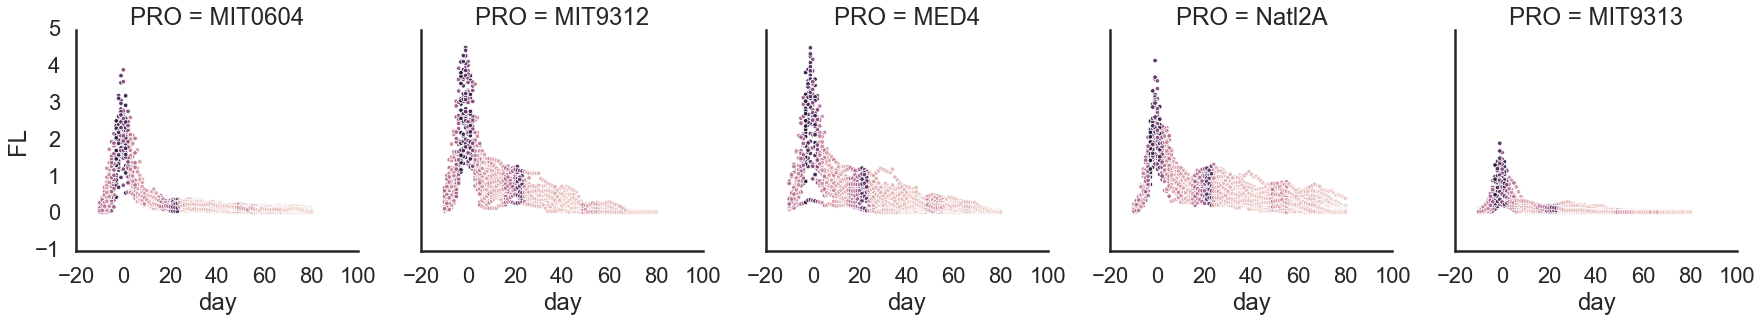

In [76]:
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

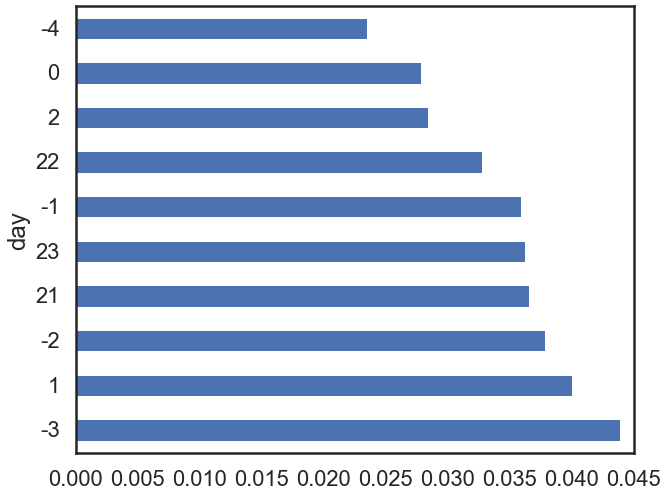

In [77]:
feature_importances56.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [78]:
feature_importances_all34 = pd.DataFrame({
    'day': [v for l in features34_list for v in l],
    'importance' :  [v for l in clf34_list for v in l.feature_importances_ ]
})
feature_importances_all56 = pd.DataFrame({
    'day': [v for l in features56_list for v in l],
    'importance' :  [v for l in clf56_list for v in l.feature_importances_ ]
})



In [79]:
feature_importances_all34.index

RangeIndex(start=0, stop=2730, step=1)

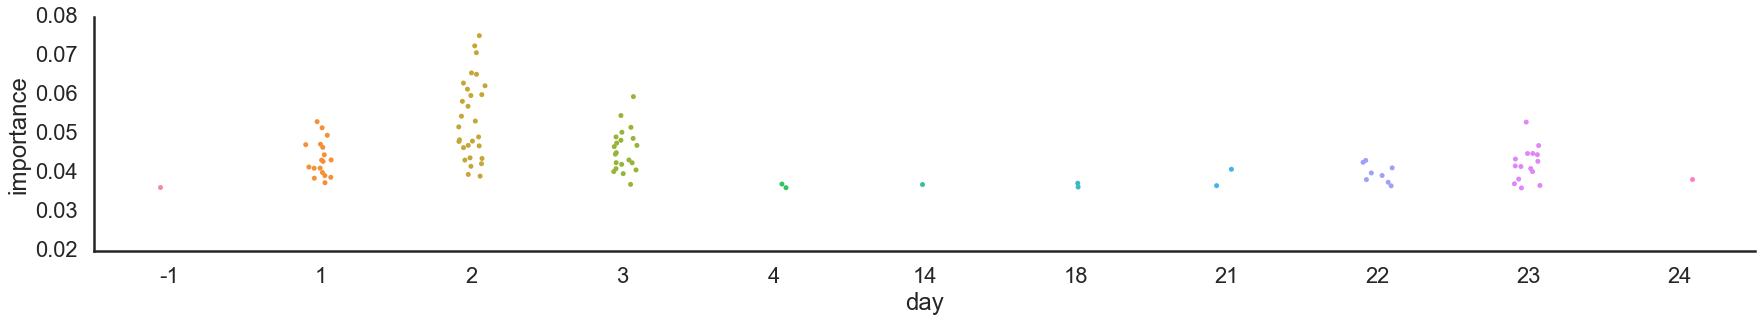

In [80]:
sns.catplot(data=feature_importances_all34.nlargest(columns='importance', n=100), x='day', y='importance',  aspect=5)

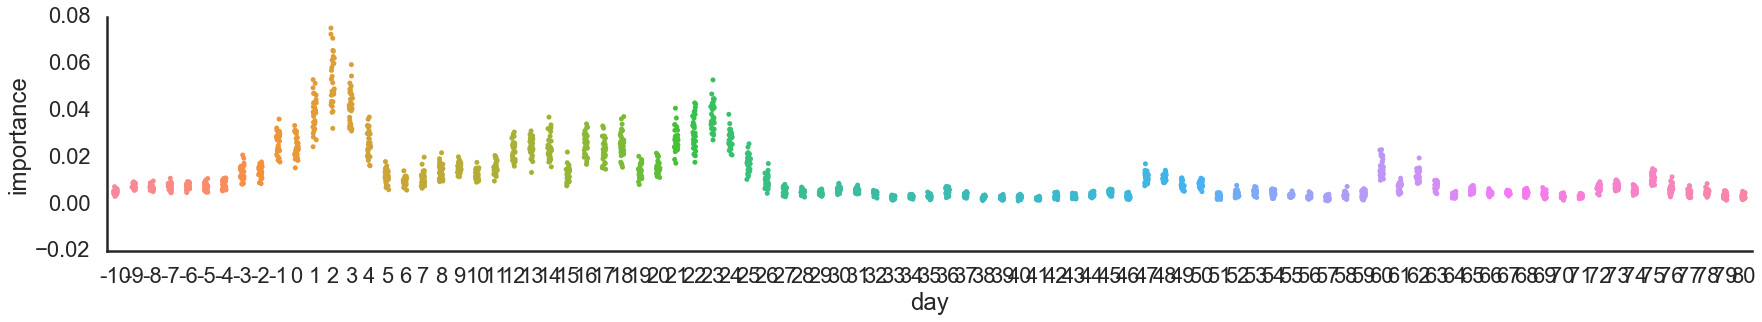

In [81]:
sns.catplot(data=feature_importances_all34, x='day', y='importance',  aspect=5)

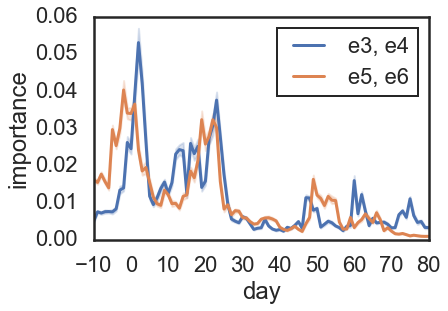

In [82]:
sns.lineplot(data=feature_importances_all34, x='day', y='importance', label='e3, e4')
sns.lineplot(data=feature_importances_all56, x='day', y='importance',   label='e5, e6')

# cluster by decline

In [49]:
value_col = 'FL'

In [50]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.56457792 0.1723785 ]


In [51]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

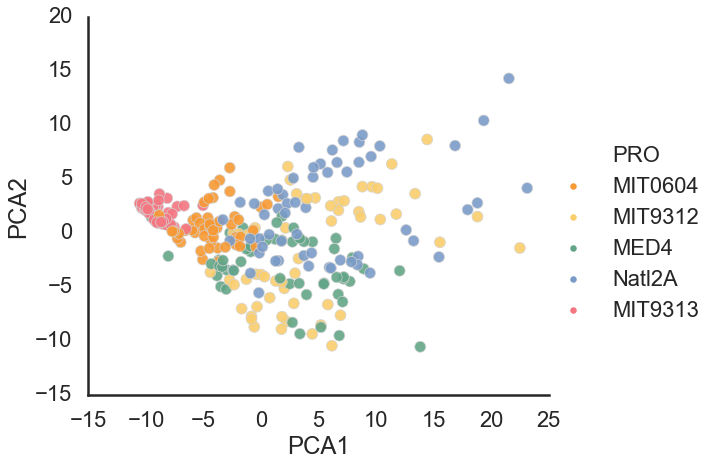

In [52]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

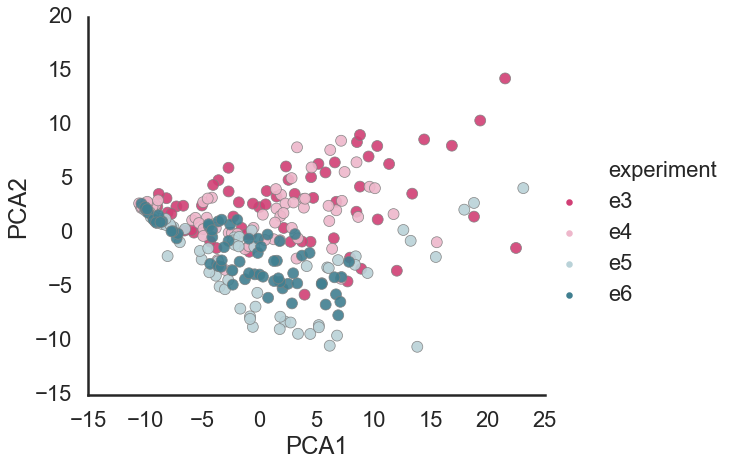

In [53]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

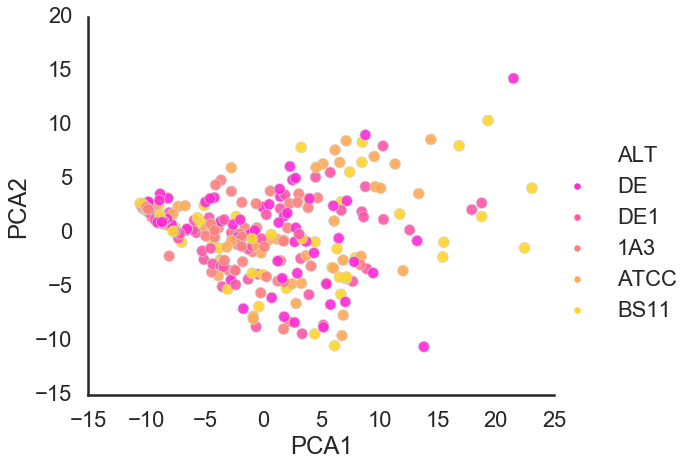

In [54]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

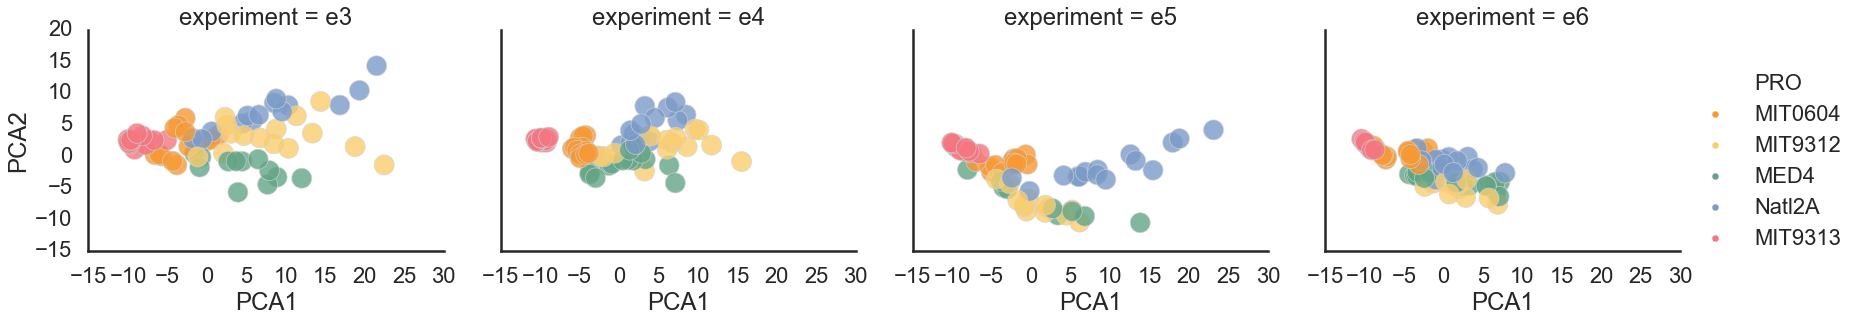

In [55]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

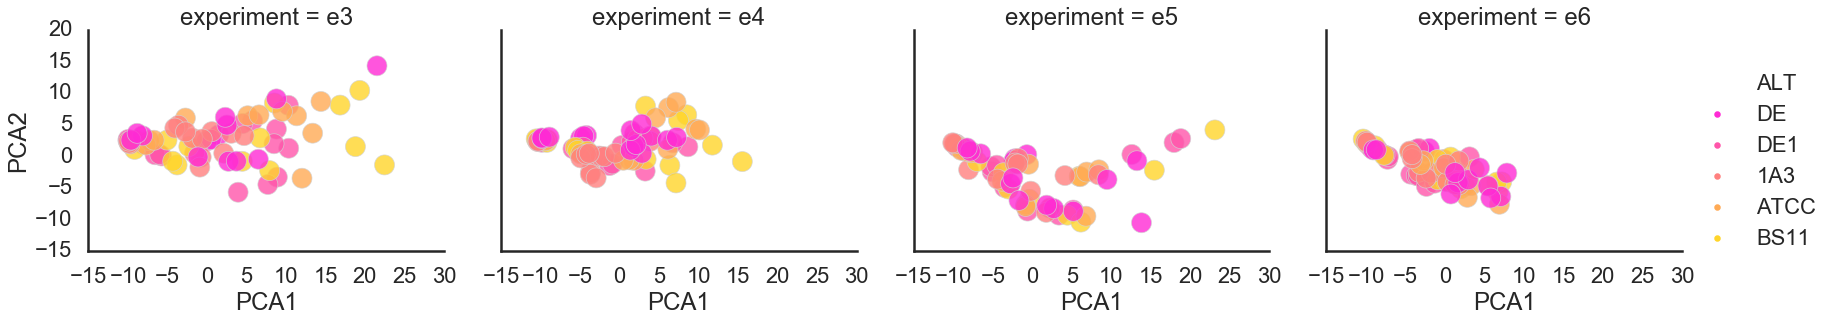

In [56]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

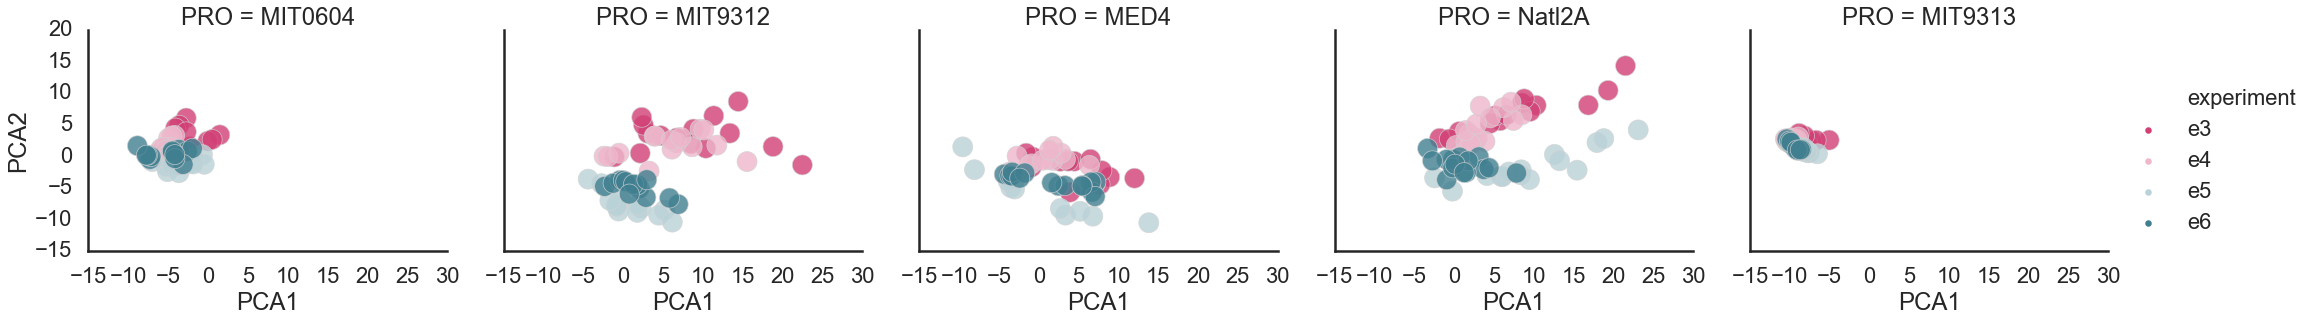

In [57]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [58]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


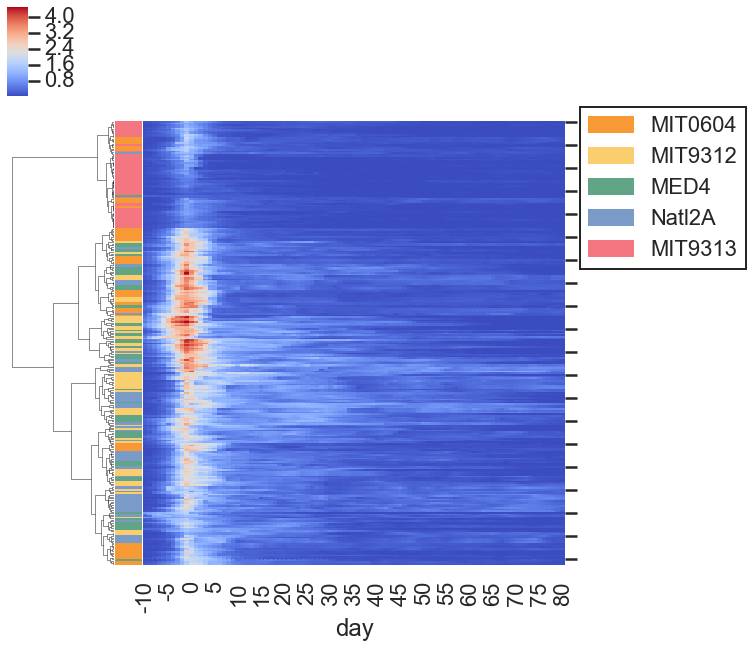

In [59]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

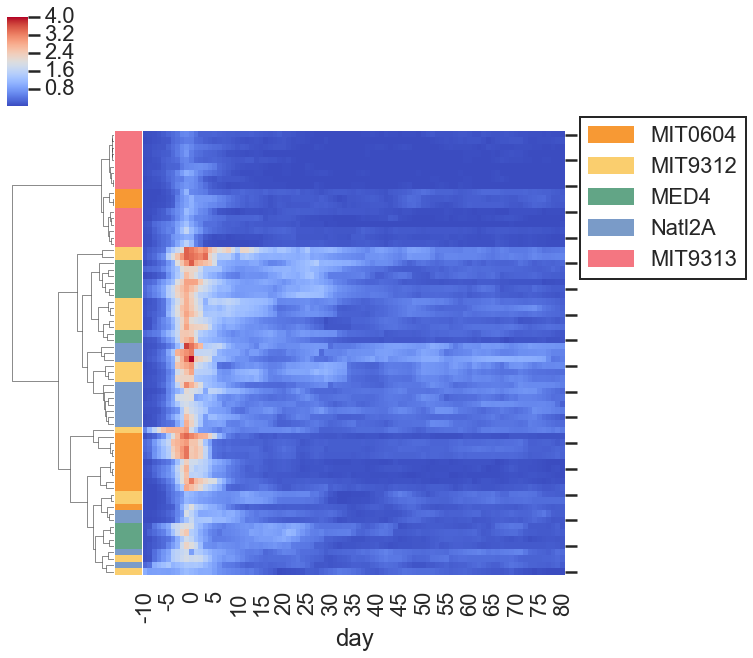

In [60]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

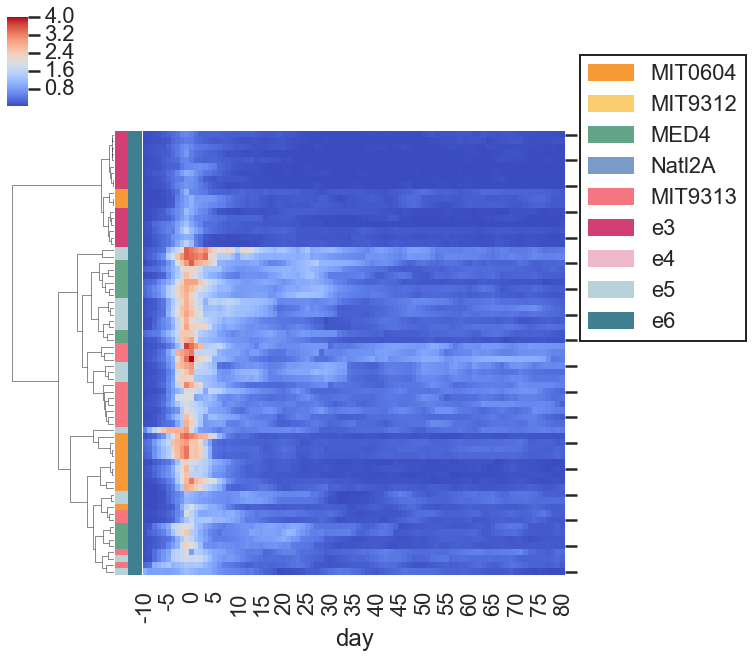

In [61]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

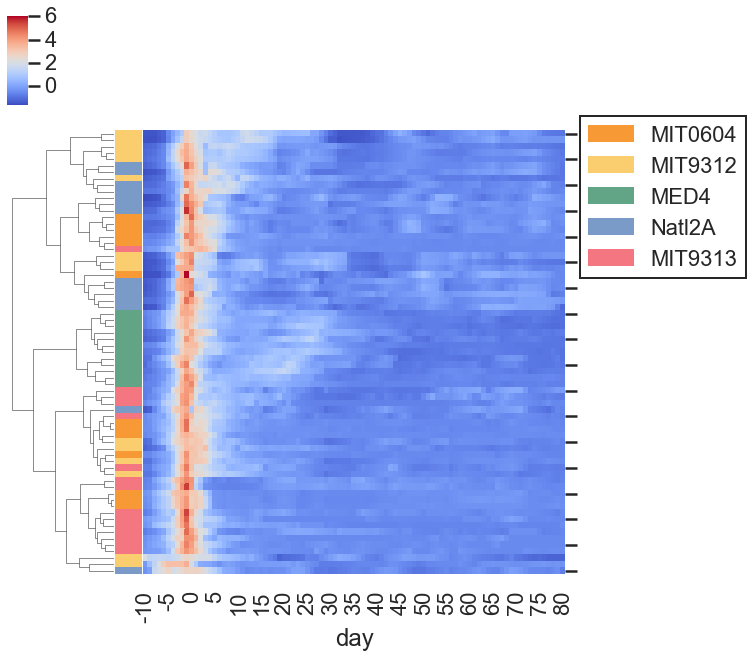

In [62]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [63]:
from sklearn.linear_model import LogisticRegression


In [64]:
import tsfresh
from tsfresh.utilities.dataframe_functions import impute


ModuleNotFoundError: No module named 'tsfresh'

In [ ]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [ ]:
ds34c = cp.update_calculated_fields(ds34, group_col='experiment_sample', add_experiment_sample=False)
ds56c = cp.update_calculated_fields(ds56, group_col='experiment_sample', add_experiment_sample=False)

df_features34 = cp.generate_features(ds34c)
df_features56 = cp.generate_features(ds56c)

In [ ]:
X_features34 = cp.features2X(df_features34)
metadf_features34 = cp.get_meta(df_features34, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features34.index = metadf_features34.experiment_sample
y34 = metadf_features34['PRO']

In [ ]:
X_features56 = cp.features2X(df_features56)
metadf_features56 = cp.get_meta(df_features56, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features56.index = metadf_features56.experiment_sample
y56 = metadf_features56['PRO']

In [ ]:
ts_f_features_df34 = tsfresh.extract_features(
    ds34c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


In [ ]:
ts_f_features_df56 = tsfresh.extract_features(
    ds56c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


In [ ]:
ts_f_features_df34 = impute(ts_f_features_df34)
ts_f_features_df56 = impute(ts_f_features_df56)

In [ ]:
scores34 = {c : compute_corr(X_features34[c], y34) for c in X_features34.columns }
scores56 = {c : compute_corr(X_features56[c], y56) for c in X_features34.columns }

In [ ]:
scores34.update({f'ts_{c}' : compute_corr(ts_f_features_df34[c], y34) for c in ts_f_features_df34.columns })
scores56.update({f'ts_{c}' : compute_corr(ts_f_features_df56[c], y56) for c in ts_f_features_df56.columns })


In [ ]:
scores34_df = pd.Series(scores34)
scores56_df = pd.Series(scores56)

In [ ]:
scores34_df.nlargest(20)

In [ ]:
scores56_df.nlargest(20)

In [ ]:
metadf

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='count', values='sample').style.apply(highlight_max)

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = len(s) != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='nunique', 
                   values='sample')# .style.apply(highlight_max)